In [1]:
import numpy as np

In [2]:

class NeuralNetwork:
    def __init__(self, input_size=784, hidden_layers=[512, 512], output_size=10):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.weights = []
        self.biases = []
        self.iterations = 0  # Initialize iterations

        # Initializes the first hidden layer
        self.weights.append(0.01 * np.random.randn(input_size, hidden_layers[0]))
        self.biases.append(np.zeros((1, hidden_layers[0])))

        # Initializes additional hidden layers
        for i in range(len(hidden_layers) - 1):
            self.weights.append(0.01 * np.random.randn(hidden_layers[i], hidden_layers[i + 1]))
            self.biases.append(np.zeros((1, hidden_layers[i + 1])))

        # Connects last hidden layer to output
        self.weights.append(0.01 * np.random.randn(hidden_layers[-1], output_size))
        self.biases.append(np.zeros((1, output_size)))

    def forward_propagation(self, inputs):
        self.outputs = [inputs]
        for i in range(len(self.weights)):
            self.outputs.append(np.dot(self.outputs[-1], self.weights[i]) + self.biases[i])
            if i == (len(self.weights) - 1):
                final_output = np.exp(self.outputs[-1] - np.max(self.outputs[-1], axis=1, keepdims=True))
                final_output /= np.sum(final_output, axis=1, keepdims=True)
                self.outputs.append(final_output)
            else:
                self.outputs.append(np.maximum(0, self.outputs[-1]))  # ReLU activation
        return self.outputs[-1]

    @staticmethod
    def loss_categorical_cross_entropy(y_pred, y_true):
        y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
        loss = -np.sum(y_true * np.log(y_pred), axis=1)
        return np.mean(loss)

    @staticmethod
    def sparse_to_one_hot(sparse_labels, num_classes):
        one_hot_encoded = np.zeros((len(sparse_labels), num_classes))
        one_hot_encoded[np.arange(len(sparse_labels)), sparse_labels] = 1
        return one_hot_encoded

    def backwards_propagation(self, y_true):
        samples = len(self.outputs[-1])

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        dSoftMaxCrossEntropy = self.outputs[-1].copy()
        dSoftMaxCrossEntropy[range(samples), y_true] -= 1
        dSoftMaxCrossEntropy /= samples  # Normalize gradient

        # Start with final layer gradients
        dInputs = dSoftMaxCrossEntropy.copy()
        dWeights = np.dot(self.outputs[-3].T, dSoftMaxCrossEntropy)
        dBiases = np.sum(dSoftMaxCrossEntropy, axis=0, keepdims=True)

        self.gradientWeights = [dWeights]
        self.gradientBiases = [dBiases]

        i = -3
        j = -1
        for _ in range(len(self.hidden_layers)):
            dInputsRelu = dInputs.copy()
            dInputsRelu[self.outputs[i] <= 0] = 0  # ReLU derivative

            i -= 1
            dInputs = np.dot(dInputsRelu, self.weights[j].T)
            dWeights = np.dot(self.outputs[i].T, dInputsRelu)
            dBiases = np.sum(dInputsRelu, axis=0, keepdims=True)

            self.gradientWeights.insert(0, dWeights)
            self.gradientBiases.insert(0, dBiases)

            j -= 1
        
    def SGD(self, lr=0.05, decay=1e-7):
        lr = lr * (1. / (1. + decay * self.iterations))

        for i in range(len(self.weights)):
            assert self.weights[i].shape == self.gradientWeights[i].shape
            self.weights[i] -= lr * self.gradientWeights[i]
            self.biases[i] -= lr * self.gradientBiases[i]

        self.iterations += 1


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

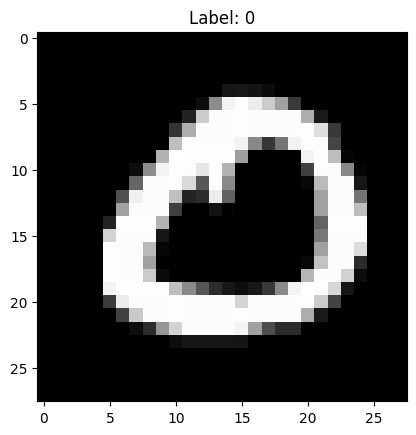

In [11]:
# Define transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the dataset
trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Fetch and display an image
dataiter = iter(trainloader)
images, labels = next(dataiter)

plt.imshow(images[0].squeeze(), cmap="gray")
plt.title(f"Label: {labels[0].item()}")
plt.show()

